In [1]:
import mne

In [3]:
edf = mne.io.read_raw_edf('../EEG_TUH_dataset/tuh_eeg/v2.0.0/edf/029/aaaaaeiq/s001_2006_06_15/02_tcp_le/aaaaaeiq_s001_t003.edf', verbose=False)

In [5]:
edf.ch_names

['EEG FP1-LE',
 'EEG FP2-LE',
 'EEG F3-LE',
 'EEG F4-LE',
 'EEG C3-LE',
 'EEG C4-LE',
 'EEG A1-LE',
 'EEG A2-LE',
 'EEG P3-LE',
 'EEG P4-LE',
 'EEG O1-LE',
 'EEG O2-LE',
 'EEG F7-LE',
 'EEG F8-LE',
 'EEG T3-LE',
 'EEG T4-LE',
 'EEG T5-LE',
 'EEG T6-LE',
 'EEG FZ-LE',
 'EEG CZ-LE',
 'EEG PZ-LE',
 'EEG OZ-LE',
 'EEG PG1-LE',
 'EEG PG2-LE',
 'EEG EKG-LE',
 'EEG 26-LE',
 'EEG 27-LE',
 'EEG 28-LE',
 'EEG 29-LE',
 'EEG 30-LE',
 'EEG 31-LE',
 'EEG 32-LE',
 'PHOTIC PH']

In [9]:
!cat ../EEG_TUH_dataset/tuh_eeg/v2.0.0/edf/029/aaaaaeiq/s001_2006_06_15/02_tcp_le/aaaaaeiq_s001_t003_date.txt

{"year":2006,"month":6,"day":15}

In [ ]:
i = 0
print(i, end='')
for p in DATA_PATH.rglob('*.edf'):
    i += 1
    if i % 100 == 0:
        print(f'\r{i}', end='')
# 68600

In [2]:
import datetime
from pathlib import Path
import json
from multiprocessing import Pool

In [28]:
all_date_time = []
size = 68600
pool_size = 40
DATA_PATH = Path('../EEG_TUH_dataset/tuh_eeg/v2.0.0/edf/')
def process_date(ind):
    cur_all_date_time = []
    i = 0
    start = size // pool_size * ind
    end = size // pool_size * (ind + 1)
    for p in DATA_PATH.rglob('*_date.txt'):
        if i < start:
            i += 1
            continue
        if i == end:
            break
        with open(p, 'r') as f:
            data = json.load(f)
        cur_all_date_time.append(datetime.datetime.strptime(f"{data['year']}-{data['month']}-{data['day']}", '%Y-%m-%d').date())
        if i % 100 == 0:
            print(f'\r{ind}: {i}', end='')
        i += 1
    return cur_all_date_time

with Pool(processes=pool_size) as p:
    res = p.map(process_date, range(pool_size))

39: 68500

In [30]:
for r in res:
    all_date_time.extend(r)

In [3]:
import matplotlib.pyplot as plt

In [44]:
sorted_date = sorted([x.year for x in all_date_time])

(array([2.1220e+03, 2.2950e+03, 2.1220e+03, 4.3880e+03, 4.4300e+03,
        6.6920e+03, 1.1812e+04, 1.9972e+04, 1.4407e+04, 5.0000e+00]),
 array([2000. , 2001.9, 2003.8, 2005.7, 2007.6, 2009.5, 2011.4, 2013.3,
        2015.2, 2017.1, 2019. ]),
 <BarContainer object of 10 artists>)

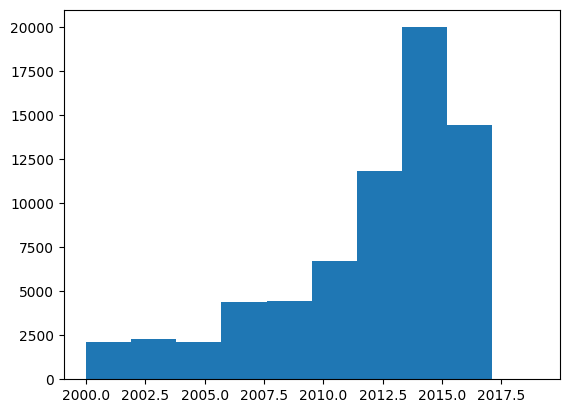

In [57]:
plt.hist(sorted_date[350:-5])

In [5]:
from collections import Counter
size = 68600
pool_size = 40
DATA_PATH = Path('../EEG_TUH_dataset/tuh_eeg/v2.0.0/edf/')
def process_eeg(ind):
    i = 0
    start = size // pool_size * ind
    end = size // pool_size * (ind + 1)
    ch_names = []
    for p in DATA_PATH.rglob('*.edf'):
        if i < start:
            i += 1
            continue
        if i == end:
            break
        edf = mne.io.read_raw_edf(p, verbose=False)
        ch_names.extend(edf.ch_names)
        if i % 100 == 0:
            print(f'\r{ind}: {i}     ', end='')
        i += 1
    return Counter(ch_names)

with Pool(processes=pool_size) as p:
    res = p.map(process_eeg, range(pool_size))

11: 18900     

/tmp/job-2319703/ipykernel_30650/3155084526.py:16: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  edf = mne.io.read_raw_edf(p, verbose=False)


15: 26600     

/tmp/job-2319703/ipykernel_30650/3155084526.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  edf = mne.io.read_raw_edf(p, verbose=False)
/tmp/job-2319703/ipykernel_30650/3155084526.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  edf = mne.io.read_raw_edf(p, verbose=False)


39: 68500     

In [6]:
from collections import defaultdict
all_ch = defaultdict(int)
for r in res:
    for ch, count in r.items():
        all_ch[ch] += count

In [8]:
import pandas as pd
channel_df = pd.DataFrame(all_ch.items(), columns=["Channel", "Count"])
channel_df = channel_df.sort_values(by="Count", ascending=False)

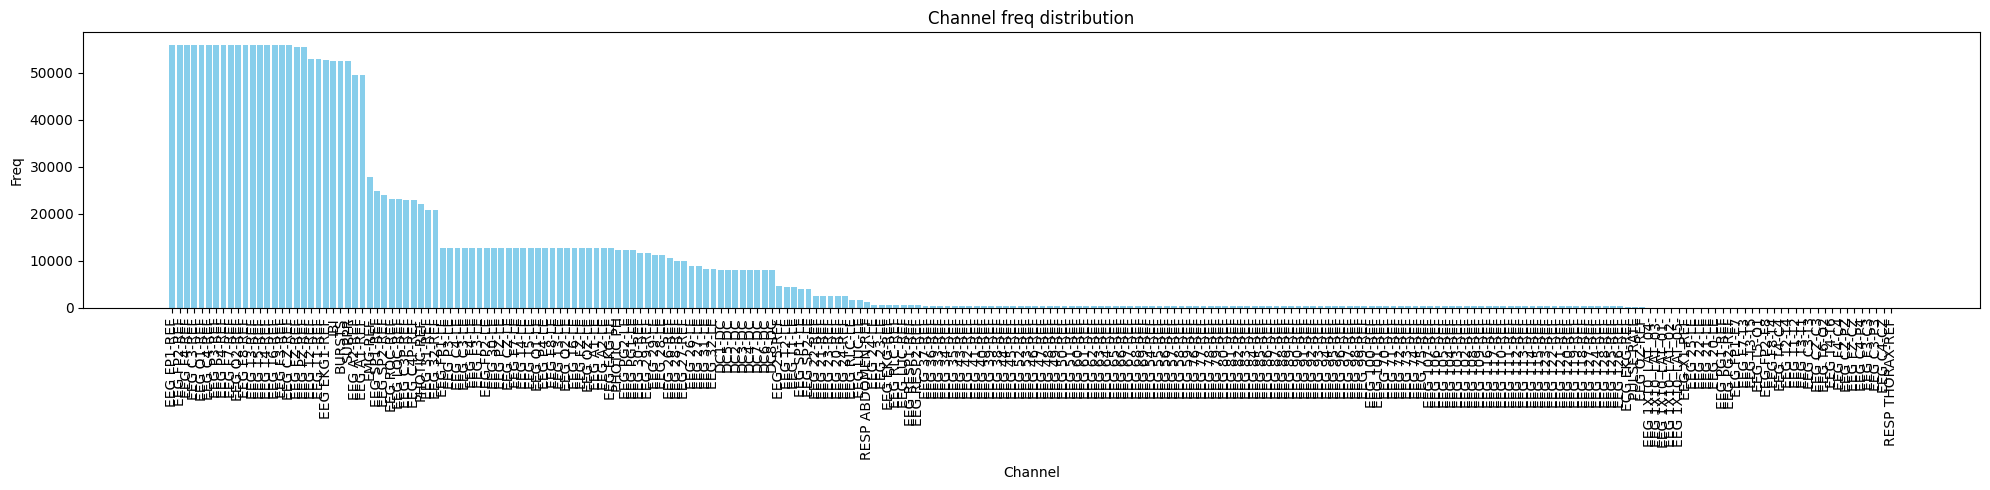

In [10]:
plt.figure(figsize=(20, 5))
plt.bar(channel_df["Channel"], channel_df["Count"], color="skyblue")
plt.xticks(rotation=90)
plt.xlabel("Channel")
plt.ylabel("Freq")
plt.title("Channel freq distribution")
plt.tight_layout()
plt.savefig("tuh_data_channel_freq.png")
plt.show()

In [19]:
channel_df_lst = [(ch, count) for ch, count in zip(channel_df["Channel"].tolist(), channel_df["Count"].tolist())]

In [22]:
ch_not_eeg = set()
for x, _ in channel_df_lst:
    if not x.startswith('EEG '):
        ch_not_eeg.add(x)
ch_not_eeg

{'BURSTS',
 'DC1-DC',
 'DC2-DC',
 'DC3-DC',
 'DC4-DC',
 'DC5-DC',
 'DC6-DC',
 'DC7-DC',
 'DC8-DC',
 'ECG EKG-REF',
 'EMG-REF',
 'IBI',
 'PHOTIC PH',
 'PHOTIC-REF',
 'PULSE RATE',
 'RESP ABDOMEN-REF',
 'RESP THORAX-REF',
 'SUPPR'}

In [37]:
THRESHHOLD = 50000
channel_df_lst_filter = [(ch if not ch.startswith('EEG ') else ch[4:-4], count) for ch, count in channel_df_lst if count > THRESHHOLD]

In [38]:
channel_df_filter = pd.DataFrame(channel_df_lst_filter, columns=["Channel", "Count"])

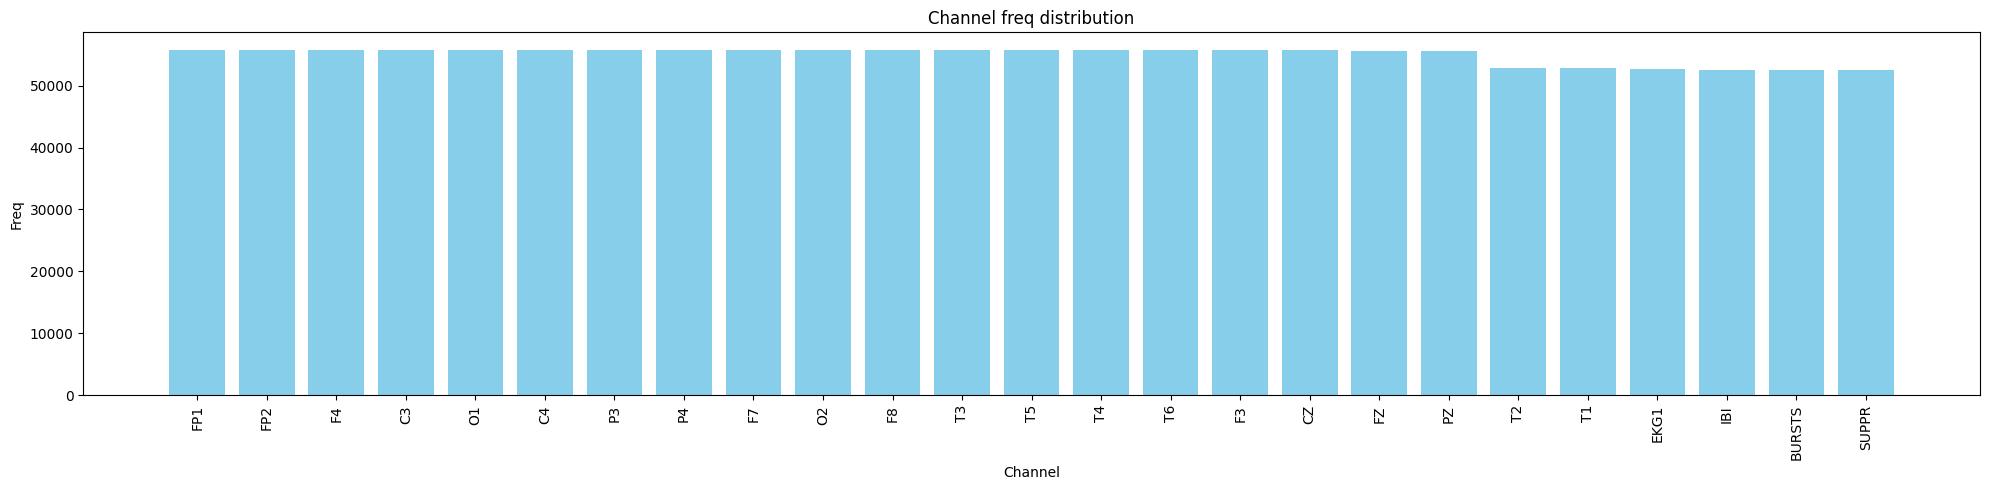

In [39]:
plt.figure(figsize=(20, 5))
plt.bar(channel_df_filter["Channel"], channel_df_filter["Count"], color="skyblue")
plt.xticks(rotation=90)
plt.xlabel("Channel")
plt.ylabel("Freq")
plt.title("Channel freq distribution")
plt.tight_layout()
plt.savefig("tuh_data_channel_freq_filter.png")
plt.show()

In [42]:
len(channel_df_filter)

25

In [47]:
[x for x in channel_df_filter['Channel']][:-4]

['FP1',
 'FP2',
 'F4',
 'C3',
 'O1',
 'C4',
 'P3',
 'P4',
 'F7',
 'O2',
 'F8',
 'T3',
 'T5',
 'T4',
 'T6',
 'F3',
 'CZ',
 'FZ',
 'PZ',
 'T2',
 'T1']